# Short Tutorial: Running VQE on IBM Quantum Hardware

## What is VQE?
The Variational Quantum Eigensolver (VQE) is a hybrid quantum-classical algorithm that finds the lowest eigenvalue of a Hamiltonian. It's particularly useful for quantum chemistry and optimization problems.

## Setting Up VQE on IBM Quantum
### 2. Connect to IBM Quantum and Select Backend

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Connect to IBM Quantum
service = QiskitRuntimeService(channel="ibm_quantum", token="") #put your token here

# Get the least busy backend (real hardware)
backend = service.least_busy(simulator=False, operational=True)
print(f"Using backend: {backend.name}")

### 3. Define Your Problem Hamiltonian

In [23]:
from qiskit.quantum_info import SparsePauliOp
H = SparsePauliOp.from_list([
    ("ZZ", -1.0),
    ("XI", -0.2),
    ("IX", -0.2)
])

### 4. Create the Ansatz Circuit

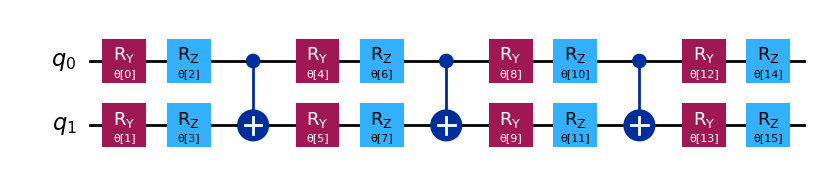

In [24]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(H.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

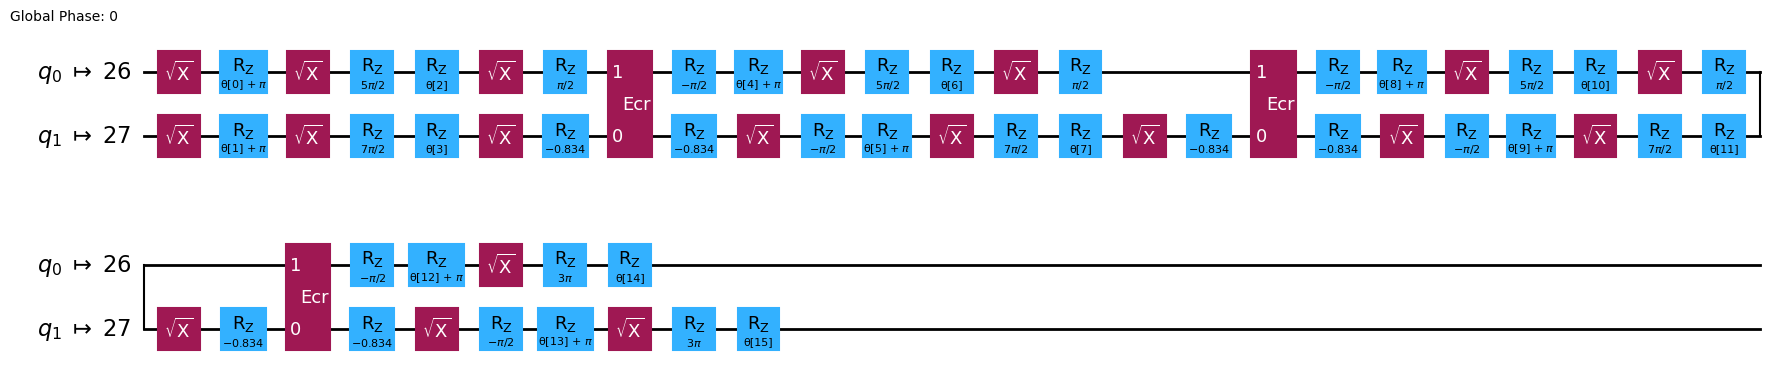

In [26]:
num_params = ansatz.num_parameters
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [27]:
hamiltonian_isa = H.apply_layout(layout=ansatz_isa.layout)

### 5. Set Up the Estimator and Cost Function

In [32]:
def cost_func(params, ansatz, H, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        H (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [H], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
x0 = 2 * np.pi * np.random.random(num_params)

### 6. Run the Optimization

In [33]:
from scipy.optimize import minimize
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    result = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

Iters. done: 1 [Current cost: -0.11089187924842733]
Iters. done: 2 [Current cost: -0.38043609291909386]
Iters. done: 3 [Current cost: -0.2726322144989981]
Iters. done: 4 [Current cost: -0.21931571455689977]
Iters. done: 5 [Current cost: -0.23373724515070554]
Iters. done: 6 [Current cost: 0.44523923933216825]
Iters. done: 7 [Current cost: -0.21166385958921818]
Iters. done: 8 [Current cost: -0.6294901661976551]
Iters. done: 9 [Current cost: -0.5752394509725889]
Iters. done: 10 [Current cost: -0.6551517784378761]
Iters. done: 11 [Current cost: -0.7079454850903446]
Iters. done: 12 [Current cost: -0.40739275985956896]
Iters. done: 13 [Current cost: -0.9794241351502375]


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


RuntimeInvalidStateError: 'Unable to retrieve result for job d0mf9c5cd8w0008sg6rg. Job was cancelled.'

# ***I intentionally stopped the job becuase it may run upto an hour and may cost me lot of money, but you can run the same job if you have credits***

## Conclusion

Congratulations! You've set up a VQE simulation for real quantum hardware. Just remember that while quantum computing is the future, your credit card bill is in the present! IBM quantum credits disappear faster than quantum coherence, and your free tier usage evaporates quicker than Schrödinger's cat making life decisions.

As quantum physicists say: "The Universe may be infinite, but your IBM Quantum budget definitely isn't." So optimize your parameters wisely, or you might find yourself explaining to your significant other why you had to remortgage the house for a few more shots on that fancy 127-qubit processor!

Happy quantum computing (and budget tracking)!